### Notebook to generate LaTeX tables

### Metrics

In [3]:
# imports
import pandas as pd
import os
import pickle
import numpy as np
import pandas as pd
import glob
import json
from rich import print as rprint
from rich.table import Table
from rich.console import Console
import gzip
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000)
pd.set_option("max_colwidth", 500)
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load CSV
metrics_path = "../metrics/concat.csv"
df = pd.read_csv(metrics_path) # path from wandb exported metrics
df = df[df["dataset_folder"] == "dataset/amazon/2023"]

# global amazon dataset mappings
DATA_NAME_MAP = {
    'beauty': 'Beauty' if "2014" in metrics_path else "All Beauty",
    'sports': 'Sports and Outdoors',
    'toys': 'Toys and Games',
    'games': 'Video Games',
    'software': 'Software',
}
INVERSE_DATA_NAME_MAP = {v: k for k, v in DATA_NAME_MAP.items()}

# Extract model from Name
def identify_model(name):
    name = name.lower()
    if "clip" in name:
        return "TIGRESS"
    elif "decoder" in name:
        return "TIGER"
    else:
        return "UNKNOWN"

def print_metrics_latex(df, only_tigress=False):
    # Filter columns
    filter_cols = ["Name", "dataset_split", 
                "metrics/recall@5", "metrics/ndcg@5", 
                "metrics/recall@10", "metrics/ndcg@10"]
    df = df[filter_cols].copy()

    if only_tigress:
        df["Model"] = "TIGRESS"
    else:
        df["Model"] = df["Name"].apply(identify_model)

    # Filter out unknowns if needed
    df = df[df["Model"] != "UNKNOWN"]

    # Pivot
    pivoted = df.pivot(index="dataset_split", columns="Model")

    # Flatten column names
    pivoted.columns = [f"{metric.replace('metrics/', '').replace('@', '_')}_{model}" for metric, model in pivoted.columns]

    # Define desired column order
    if only_tigress:
        expected_cols = ['recall_5_TIGRESS', 'ndcg_5_TIGRESS', 'recall_10_TIGRESS', 'ndcg_10_TIGRESS']
    else:
        expected_cols = ['recall_5_TIGER', 'ndcg_5_TIGER', 'recall_10_TIGER', 'ndcg_10_TIGER',
                        'recall_5_TIGRESS', 'ndcg_5_TIGRESS', 'recall_10_TIGRESS', 'ndcg_10_TIGRESS']

    # Ensure columns exist
    missing = [c for c in expected_cols if c not in pivoted.columns]
    if missing:
        print("Available columns:", pivoted.columns.tolist())
        raise KeyError(f"Missing expected columns: {missing}")

    # Reorder
    pivoted = pivoted[expected_cols].round(4)

    # Bold max values
    def bold_max(row, metric):
        if only_tigress:
            t=0
        else:
            t = row[f"{metric}_TIGER"]
        tr = row[f"{metric}_TIGRESS"]
        if t > tr:
            return f"\\textbf{{{t:.4f}}}", f"{tr:.4f}"
        elif tr > t:
            return f"{t:.4f}", f"\\textbf{{{tr:.4f}}}"
        else:
            return f"{t:.4f}", f"{tr:.4f}"

    # Generate LaTeX rows
    latex_rows = []
    pivoted = pivoted.reindex(DATA_NAME_MAP.keys())
    for category, row in pivoted.iterrows():
        r5_t, r5_tr = bold_max(row, "recall_5")
        n5_t, n5_tr = bold_max(row, "ndcg_5")
        r10_t, r10_tr = bold_max(row, "recall_10")
        n10_t, n10_tr = bold_max(row, "ndcg_10")
        latex_rows.append(
            f"{DATA_NAME_MAP[category]} & {r5_t} & {n5_t} & {r10_t} & {n10_t} & {r5_tr} & {n5_tr} & {r10_tr} & {n10_tr} \\\\"
        )

    # Final LaTeX table
    latex_table = r"""
    \begin{table}[ht]
    \centering
    \resizebox{1\textwidth}{!}{%
    \begin{tabular}{lcccccccc}
        \toprule
        \textbf{Category} & \multicolumn{4}{c}{\textbf{TIGER}} & \multicolumn{4}{c}{\textbf{TIGRESS}} \\
        \cmidrule(r){2-5} \cmidrule(l){6-9}
        & \textbf{Recall@5} & \textbf{NDCG@5} & \textbf{Recall@10} & \textbf{NDCG@10}
        & \textbf{Recall@5} & \textbf{NDCG@5} & \textbf{Recall@10} & \textbf{NDCG@10} \\
        \midrule
    """ + "\n".join(latex_rows) + r"""
        \bottomrule
        \end{tabular}
        }
    \vspace{1mm}
    \caption{Comparison of TIGER and TIGRESS on Recall and NDCG at cutoff 5 and 10 across categories.}
    \label{tab:tiger_vs_tigress}
    \end{table}
    """

    print(latex_table)
    
print_metrics_latex(df.copy(), only_tigress=True)


    \begin{table}[ht]
    \centering
    \resizebox{1\textwidth}{!}{%
    \begin{tabular}{lcccccccc}
        \toprule
        \textbf{Category} & \multicolumn{4}{c}{\textbf{TIGER}} & \multicolumn{4}{c}{\textbf{TIGRESS}} \\
        \cmidrule(r){2-5} \cmidrule(l){6-9}
        & \textbf{Recall@5} & \textbf{NDCG@5} & \textbf{Recall@10} & \textbf{NDCG@10}
        & \textbf{Recall@5} & \textbf{NDCG@5} & \textbf{Recall@10} & \textbf{NDCG@10} \\
        \midrule
    All Beauty & 0.0000 & 0.0000 & 0.0000 & 0.0000 & \textbf{0.0474} & \textbf{0.0421} & \textbf{0.0593} & \textbf{0.0456} \\
Sports and Outdoors & 0.0000 & 0.0000 & 0.0000 & 0.0000 & \textbf{0.1309} & \textbf{0.1115} & \textbf{0.1400} & \textbf{0.1145} \\
Toys and Games & 0.0000 & 0.0000 & 0.0000 & 0.0000 & \textbf{0.2196} & \textbf{0.1560} & \textbf{0.2533} & \textbf{0.1672} \\
Video Games & 0.0000 & 0.0000 & 0.0000 & 0.0000 & \textbf{0.1088} & \textbf{0.0806} & \textbf{0.1342} & \textbf{0.0889} \\
Software & 0.0000 & 0.0000 & 0.000

#### Plotting IR Measures

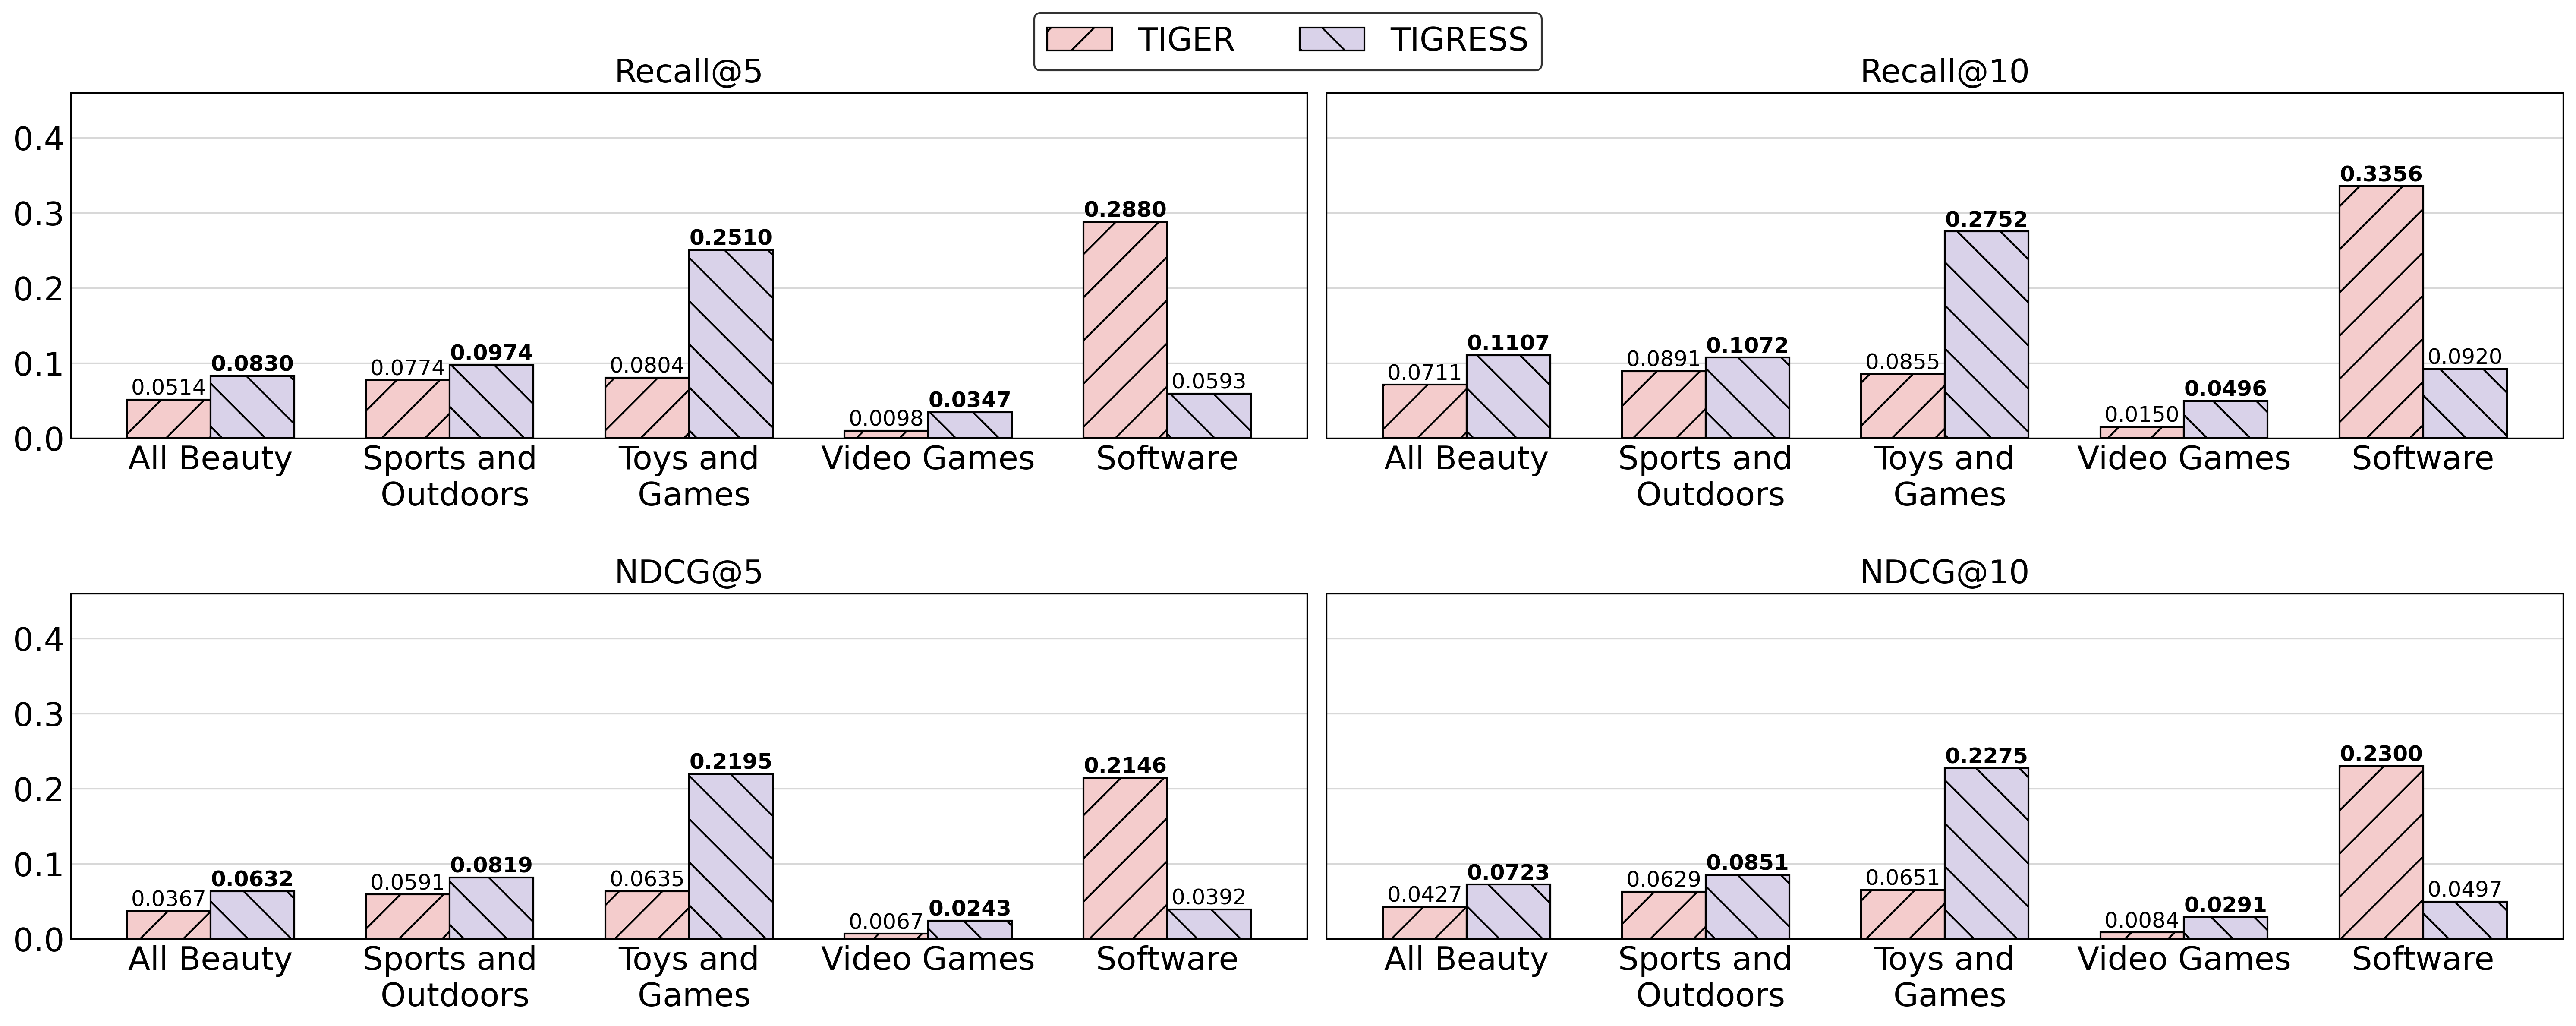

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

def plot_scores_barplot(plot_df, year):
    # Variables for colors and font sizes
    color_tiger = "#f4cccc"     # pastel red
    color_tigress = "#d9d2e9"   # pastel purple
    bar_edge_color = "black"
    fontsize_scores = 16 if year == "2014" else 12
    fontsize_labels = 18
    fontsize_title = 18
    dpi_val = 300

    # Map colors based on 'Name'
    color_map = {"TIGER": color_tiger, "TIGRESS": color_tigress}
    plot_df["color"] = plot_df["Name"].map(color_map)

    
    metrics = ["metrics/recall@5", "metrics/recall@10", "metrics/ndcg@5", "metrics/ndcg@10"]
    titles = ["Recall@5", "Recall@10", "NDCG@5", "NDCG@10"]


    fig, axes = plt.subplots(2, 2, figsize=(20, 8), dpi=dpi_val, sharey=True)
    axes = axes.flatten()
    desired_order = list(DATA_NAME_MAP.values())
    
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Prepare data for grouped bars: group by dataset_split and Name
        data_pivot = plot_df.pivot(index="dataset_split", columns="Name", values=metric)
        data_pivot = data_pivot.reindex(desired_order).dropna(how='all')
        
        dataset_splits = data_pivot.index.tolist()
        x = np.arange(len(dataset_splits))
        width = 0.35
        
        bars_tiger = ax.bar(x - width/2, data_pivot["TIGER"], width,
                           color=color_tiger, edgecolor=bar_edge_color, label="TIGER", hatch="/")
        bars_tigress = ax.bar(x + width/2, data_pivot["TIGRESS"], width,
                              color=color_tigress, edgecolor=bar_edge_color, label="TIGRESS", hatch="\\")

        # Grid lines on y-axis only
        ax.grid(axis='y', linestyle='-', color='gray', alpha=0.3)
        ax.set_axisbelow(True)
        
        # X tick labels without xlabel
        ax.set_xticks(x)
        labels = [label.replace('and', 'and\n').strip() for label in dataset_splits]
        ax.set_xticklabels(labels, fontsize=fontsize_labels)

        # Y axis label only on the first subplot (top-left)
        # if i == 0:
        #     ax.set_ylabel("Score", fontsize=fontsize_labels)

        # Title with bigger font
        ax.set_title(titles[i], fontsize=fontsize_title)

        # Annotate bars with scores and bold max pair score
        for idx in range(len(dataset_splits)):
            
            val_tigress = data_pivot.loc[dataset_splits[idx], "TIGRESS"]
            val_tiger = data_pivot.loc[dataset_splits[idx], "TIGER"]

            weight_tigress = 'bold' if val_tigress > val_tiger else 'normal'
            weight_tiger = 'bold' if val_tiger > val_tigress else 'normal'

            offset = 0.001
            ax.text(x[idx] - width/2, val_tiger + offset, f"{val_tiger:.4f}",
                    ha='center', va='bottom', fontsize=fontsize_scores, fontweight=weight_tiger, color='black')
            ax.text(x[idx] + width/2, val_tigress + offset, f"{val_tigress:.4f}",
                    ha='center', va='bottom', fontsize=fontsize_scores, fontweight=weight_tigress, color='black')


            
    # Set Y-limit once per axis
    ymax = data_pivot.to_numpy().max() * 2
    ax.set_ylim(0, ymax)


    # Remove xlabel for all subplots explicitly (redundant but safe)
    for ax in axes:
        ax.set_xlabel("")
        ax.margins(y=0.2)
        ax.tick_params(axis='y', which='both', length=0, labelsize=fontsize_labels)  # no y ticks
        ax.tick_params(axis='x', which='both', length=0)  # no x ticks

    # One single legend outside the plots on the right side
    handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right', fontsize=fontsize_labels, frameon=False)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1),
           ncol=2, fontsize=fontsize_title, frameon=True, edgecolor='black')

    # plt.subplots_adjust(right=0.85, wspace=0.25, hspace=0.25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if year == "2014":
        plt.subplots_adjust(hspace=0.3)
    else:
        plt.subplots_adjust(hspace=0.45)
    plt.show()


# Load CSV
year = "2023"
metrics_path = f"../../metrics/{year}.csv"
plot_df = pd.read_csv(metrics_path) # path from wandb exported metrics


# global amazon dataset mappings
DATA_NAME_MAP = {
    'beauty': 'Beauty' if "2014" in year else "All Beauty",
    'sports': 'Sports and Outdoors',
    'toys': 'Toys and Games',
    'games': 'Video Games',
    'software': 'Software',
}

plot_df["Name"] = plot_df["Name"].apply(identify_model)
cols = ["Name", "dataset_split", "metrics/recall@5", "metrics/ndcg@5", "metrics/recall@10", "metrics/ndcg@10"]
plot_df["dataset_split"] = plot_df["dataset_split"].map(DATA_NAME_MAP)
plot_df = plot_df[cols]


plot_scores_barplot(plot_df.copy(), year)

### Fairness and Diversity

In [10]:
# Load CSV
fd_df = pd.read_csv("../metrics/fairness2.csv") # path from wandb exported metrics

# fairness and diversity metrics
FD_METRICS = ["gini", "coverage", "brand", "relative"]

only_tigress = True

# Extract model from Name
def identify_model(name):
    name = name.lower()
    if "clip" in name:
        return "TIGRESS"
    else:
        return "TIGER"
    
    
extract_year = lambda x: "2023" if "2023" in x else "2014"
fd_df["year"] = fd_df["Name"].apply(extract_year)

def print_fd_latex(df):
    # fitlering
    filter_cols = ["Name", "dataset_split", 
                   "metrics/gini@5", "metrics/gini@10",
                   "fairness/brand_coverage@5", "fairness/brand_coverage@10",
                   "fairness/coverage@5", "fairness/coverage@10",
                   "fairness/relative_disparity@5", "fairness/relative_disparity@10",
                   ]
    df = df[filter_cols].copy()

    df["Model"] = df["Name"].apply(identify_model)
    df = df[df["Model"] != "UNKNOWN"]

    # pivot
    pivoted = df.pivot(index="dataset_split", columns=["Model"])
    pivoted.columns = [f"{metric.replace('metrics/', '').replace('fairness/', '').replace('@', '_')}_{model}" for metric, model in pivoted.columns]
    # desired column order
    metric_cols = [c for c in pivoted.columns if c.split("_")[0] in FD_METRICS]
    missing = [c for c in metric_cols if c not in pivoted.columns]
    if missing:
        print("Available columns:", pivoted.columns.tolist())
        raise KeyError(f"Missing expected columns: {missing}")
    pivoted = pivoted[metric_cols].round(4)

    # Bold max values
    def bold_max(row, metric):   
        t = 0
        if not only_tigress:         
            t = row[f"{metric}_TIGER"]
        tr = row[f"{metric}_TIGRESS"]
        if t > tr:
            if "gini" in metric or "relative" in metric:
                return f"{t:.4f}", f"\\textBF{{{tr:.4f}}}"
            else:
                return f"\\textBF{{{t:.4f}}}", f"{tr:.4f}"
        elif tr > t:
            if "gini" in metric or "relative" in metric:
                return f"\\textBF{{{t:.4f}}}", f"{tr:.4f}"
            else:
                return f"{t:.4f}", f"\\textBF{{{tr:.4f}}}"
        else:
            return f"{t:.4f}", f"{tr:.4f}"
        

    # Generate LaTeX rows
    fairness_rows, diversity_rows = [], []
    for category, row in pivoted.iterrows():
        gini_5_t, gini_5_tr = bold_max(row, "gini_5")
        gini_10_t, gini_10_tr = bold_max(row, "gini_10")
        item_cov_5_t, item_cov_5_tr = bold_max(row, "coverage_5")
        item_cov_10_t, item_cov_10_tr = bold_max(row, "coverage_10")
        brand_cov_5_t, brand_cov_5_tr = bold_max(row, "brand_coverage_5")
        brand_cov_10_t, brand_cov_10_tr = bold_max(row, "brand_coverage_10")
        rel_dis_5_t, rel_dis_5_tr = bold_max(row, "relative_disparity_5")
        rel_dis_10_t, rel_dis_10_tr = bold_max(row, "relative_disparity_10")
        fairness_rows.append(
            f"{DATA_NAME_MAP[category]} & {gini_5_t} & {rel_dis_5_t} \
            & {gini_10_t} & {rel_dis_10_t} \
            & {gini_5_tr} & {rel_dis_5_tr} \
            & {gini_10_tr} & {rel_dis_10_tr} \\\\"
        )
        diversity_rows.append(
            f"{DATA_NAME_MAP[category]} & {item_cov_5_t} & {brand_cov_5_t} \
            & {item_cov_10_t} & {brand_cov_10_t} \
            & {item_cov_5_tr} & {brand_cov_5_tr} \
            & {item_cov_10_tr} & {brand_cov_10_tr} \\\\"
        )

    fairness_latex_table = r"""
    \begin{table}[ht]
    \centering
    \resizebox{1\textwidth}{!}{%
    \begin{tabular}{lcccccccc}
        \toprule
        \textbf{Category} 
        & \multicolumn{4}{c}{\textbf{TIGER}} 
        & \multicolumn{4}{c}{\textbf{TIGRESS}} \\
        \cmidrule(lr){2-5} \cmidrule(lr){6-9}
        & \textbf{Gini@5} &  \textbf{RelDisparity@5} 
        & \textbf{Gini@10} &  \textbf{RelDisparity@10} 
        & \textbf{Gini@5} &  \textbf{RelDisparity@5} 
        & \textbf{Gini@10} &  \textbf{RelDisparity@10} \\
        \midrule
    """ + "\n".join(fairness_rows) + r"""
        \bottomrule
        \end{tabular}
    }
    \vspace{1mm}
    \caption{Comparison of TIGER and TIGRESS on fairness metrics at cutoffs 5 and 10 across categories.}
    \label{tab:tiger_vs_tigress_fairness}
    \end{table}
    """
    
    diversity_latex_table = r"""
    \begin{table}[ht]
    \centering
    \resizebox{1\textwidth}{!}{%
    \begin{tabular}{lcccccccc}
        \toprule
        \textbf{Category} 
        & \multicolumn{4}{c}{\textbf{TIGER}} 
        & \multicolumn{4}{c}{\textbf{TIGRESS}} \\
        \cmidrule(lr){2-5} \cmidrule(lr){6-9}
        & \textbf{ItemCov@5} & \textbf{BrandCov@5} 
        & \textbf{ItemCov@10} & \textbf{BrandCov@10} 
        & \textbf{ItemCov@5} & \textbf{BrandCov@5} 
        & \textbf{ItemCov@10} & \textbf{BrandCov@10} \\
        \midrule
    """ + "\n".join(diversity_rows) + r"""
        \bottomrule
        \end{tabular}
    }
    \vspace{1mm}
    \caption{Comparison of TIGER and TIGRESS on diversity metrics at cutoffs 5 and 10 across categories.}
    \label{tab:tiger_vs_tigress_diversity}
    \end{table}
    """

    print("Fairness Table")
    print(fairness_latex_table)
    print("Diversity Table")
    print(diversity_latex_table)

year = "2023"

# global amazon dataset mappings
DATA_NAME_MAP = {
    'beauty': 'Beauty' if "2014" in year else "All Beauty",
    'toys': 'Toys and Games',
    'sports': 'Sports and Outdoors',
    'games': 'Video Games',
    'software': 'Software',
}

fd_df = fd_df[fd_df["year"] == year]
print_fd_latex(fd_df.copy())

Fairness Table

    \begin{table}[ht]
    \centering
    \resizebox{1\textwidth}{!}{%
    \begin{tabular}{lcccccccc}
        \toprule
        \textbf{Category} 
        & \multicolumn{4}{c}{\textbf{TIGER}} 
        & \multicolumn{4}{c}{\textbf{TIGRESS}} \\
        \cmidrule(lr){2-5} \cmidrule(lr){6-9}
        & \textbf{Gini@5} &  \textbf{RelDisparity@5} 
        & \textbf{Gini@10} &  \textbf{RelDisparity@10} 
        & \textbf{Gini@5} &  \textbf{RelDisparity@5} 
        & \textbf{Gini@10} &  \textbf{RelDisparity@10} \\
        \midrule
    All Beauty & \textBF{0.0000} & \textBF{0.0000}             & \textBF{0.0000} & \textBF{0.0000}             & 0.0411 & 0.3778             & 0.0927 & 0.6041 \\
Video Games & \textBF{0.0000} & \textBF{0.0000}             & \textBF{0.0000} & \textBF{0.0000}             & 0.1002 & 0.3516             & 0.2231 & 0.3241 \\
Software & 0.0000 & \textBF{0.0000}             & 0.0000 & \textBF{0.0000}             & 0.0000 & 0.0771             & 0.0000 & 0.0878 \\

#### Plot FD Measures

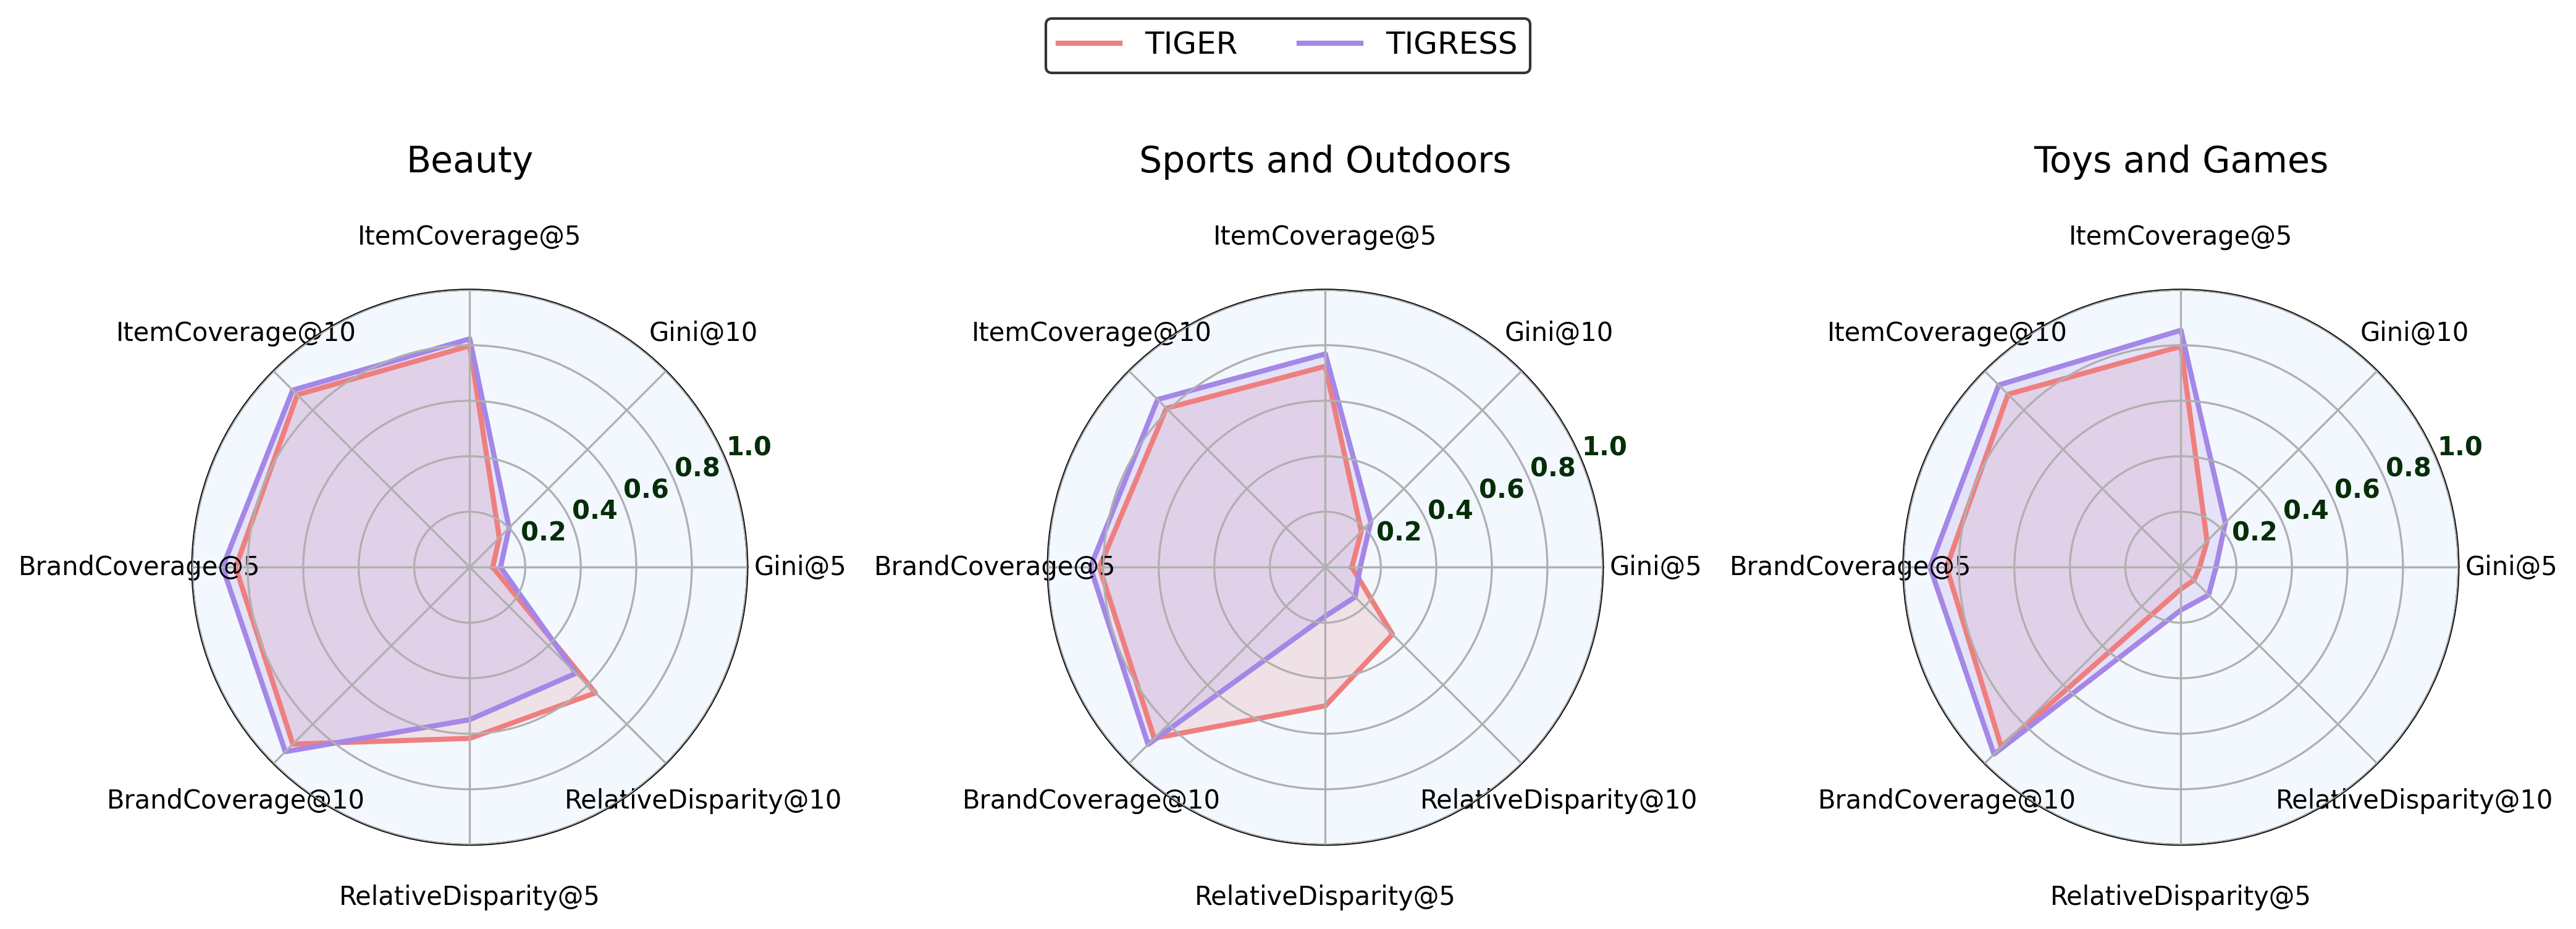

In [202]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
plt.rcParams["axes.axisbelow"] = False
import matplotlib.gridspec as gridspec

def plot_scores_radar(plot_df, year):
    color_tiger = "#ef7f7f"     # pastel red
    color_tigress = "#a487e7"   # pastel purple
    fontsize_labels = 10 if year == "2014" else 12
    fontsize_title = 12 if year == "2014" else 14
    dpi_val = 300
    
    metrics = ["metrics/gini@5", "metrics/gini@10",
               "fairness/coverage@5", "fairness/coverage@10",
               "fairness/brand_coverage@5", "fairness/brand_coverage@10",
               "fairness/relative_disparity@5", "fairness/relative_disparity@10"]
    titles = ["Gini@5", "Gini@10", 
              "ItemCoverage@5", "ItemCoverage@10",
              "BrandCoverage@5", "BrandCoverage@10", 
              "RelativeDisparity@5", "RelativeDisparity@10"]
    
    desired_order = list(DATA_NAME_MAP.values())  # maintain your dataset order
    
    # Only keep dataset_splits present in the data
    dataset_splits = [ds for ds in desired_order if ds in plot_df["dataset_split"].values]
    
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # close the circle
    
    num_plots = len(dataset_splits)
    if year == "2014":
        fig, axes = plt.subplots(1, num_plots, figsize=(14, 7), dpi=dpi_val, subplot_kw=dict(polar=True))
    else:
        # fig, axes = plt.subplots(1, num_plots, figsize=(22, 6), dpi=dpi_val, subplot_kw=dict(polar=True))
        fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=dpi_val, subplot_kw=dict(polar=True))
        axes = axes.flatten()
        if len(dataset_splits) < len(axes):
            for i in range(len(dataset_splits), len(axes)):
                fig.delaxes(axes[i])
        axes = axes[:len(dataset_splits)]
        # fig = plt.figure(figsize=(20, 12), dpi=dpi_val)
        # gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
        # axes = []
        # for i in range(len(dataset_splits)):
        #     if i < 4:
        #         ax = fig.add_subplot(gs[0, i], polar=True)
        #     else:
        #         ax = fig.add_subplot(gs[1, 1:3], polar=True)
        #     axes.append(ax)
            
    if num_plots == 1:
        axes = [axes]
    
    for i, dataset in enumerate(dataset_splits):
        ax = axes[i]
        ax.set_title(dataset, fontsize=fontsize_title+2, pad=20)
        
        for model, color in zip(["TIGER", "TIGRESS"], [color_tiger, color_tigress]):
            values = plot_df[(plot_df["dataset_split"] == dataset) & (plot_df["Name"] == model)][metrics].values.flatten().tolist()
            if len(values) == 0:
                continue
            values += values[:1]  # close the circle
            
            ax.plot(angles, values, color=color, linewidth=2, label=model)
            ax.fill(angles, values, color=color, alpha=0.25)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(titles, fontsize=fontsize_labels) # metrics
        ax.tick_params(axis='y', labelsize=fontsize_labels) # 0 to 1 scale
        ax.tick_params(axis='x', pad=10)
        ax.tick_params(axis='y', labelrotation=0, labelleft=True, pad=15)
        
        
        # Add pastel green band from 0 to 1 radius
        if year == "2014":
            ax.set_ylim(0, max(plot_df[metrics].max().max(), 1))
            theta = np.linspace(0, 2 * np.pi, 100)
            r_inner = np.zeros_like(theta)
            r_outer = np.ones_like(theta)
            ax.fill_between(theta, r_inner, r_outer, color="#DAE8FC", alpha=0.3)
        else:
            ax.set_ylim(0, max(plot_df[metrics].max().max(), 1))
            ax.set_rgrids(np.linspace(0.2, 1.0, 5), angle=90)
            ax.set_frame_on(False)
            
            theta = np.linspace(0, 2 * np.pi, 100)
            r_inner = np.zeros_like(theta)
            r_outer = np.ones_like(theta)
            ax.fill_between(theta, r_inner, r_outer, color="#DAE8FC", alpha=0.3)
        
        for label in ax.get_yticklabels():
            label.set_color("#052e08")
            label.set_fontweight("bold")

    
        # Bring all text elements to front
        # for text in ax.texts + ax.get_xticklabels() + ax.get_yticklabels():
        #     text.set_zorder(10)
        #     ax.set_axisbelow(False)
        
        
        # for tickline in ax.yaxis.get_ticklines():
        #     tickline.set_zorder(9)
            
    
    # One single legend outside the plots on the right side
    handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right', fontsize=fontsize_labels, frameon=False)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9),
           ncol=2, fontsize=fontsize_title, frameon=True, edgecolor='black')
    
    if year == "2014":
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.subplots_adjust(hspace=0.5)
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.83])
        plt.subplots_adjust(wspace=0.75, hspace=0.5)
    

    # plt.savefig("fairness_plot.png", transparent=True, dpi=dpi_val)
    plt.show()



# Load CSV
year = "2014"
metrics_path = f"../../metrics/fairness.csv"
plot_df = pd.read_csv(metrics_path) # path from wandb exported metrics


# global amazon dataset mappings
DATA_NAME_MAP = {
    'beauty': 'Beauty' if "2014" in year else "All Beauty",
    'sports': 'Sports and Outdoors',
    'toys': 'Toys and Games',
    'games': 'Video Games',
    'software': 'Software',
}

extract_year = lambda x: "2023" if "2023" in x else "2014"
plot_df["year"] = plot_df["Name"].apply(extract_year)
plot_df = plot_df[plot_df["year"] == year]

# Extract model from Name
def identify_model(name):
    name = name.lower()
    if "clip" in name:
        return "TIGRESS"
    else:
        return "TIGER"
    
plot_df["Name"] = plot_df["Name"].apply(identify_model)

cols = ["Name", "dataset_split", 
        "metrics/gini@5", "metrics/gini@10",
        "fairness/brand_coverage@5", "fairness/brand_coverage@10",
        "fairness/coverage@5", "fairness/coverage@10",
        "fairness/relative_disparity@5", "fairness/relative_disparity@10",
        ]
plot_df["dataset_split"] = plot_df["dataset_split"].map(DATA_NAME_MAP)
plot_df = plot_df[cols]


plot_scores_radar(plot_df.copy(), year)

In [203]:
plot_df

,Name,dataset_split,metrics/gini@5,metrics/gini@10,fairness/brand_coverage@5,fairness/brand_coverage@10,fairness/coverage@5,fairness/coverage@10,fairness/relative_disparity@5,fairness/relative_disparity@10
10,TIGRESS,Toys and Games,0.126419,0.226450,0.904150,0.952569,0.853956,0.928405,0.154427,0.141119
11,TIGRESS,Sports and Outdoors,0.125730,0.231431,0.846809,0.903191,0.768742,0.854701,0.176636,0.151776
12,TIGRESS,Beauty,0.110999,0.200556,0.890710,0.939891,0.822978,0.902328,0.549236,0.540594
13,TIGER,Toys and Games,0.067312,0.133102,0.844595,0.915541,0.796034,0.881210,0.078333,0.066080
14,TIGER,Beauty,0.082777,0.150490,0.843683,0.901499,0.797965,0.878879,0.616713,0.640290
15,TIGER,Sports and Outdoors,0.095727,0.183133,0.814047,0.871652,0.724114,0.810128,0.499490,0.342217


### Datasets

In [39]:
def parse(path):
    g = gzip.open(path, "r")
    for l in g:
        yield eval(l)
        
def parse_2023(path):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Parsing {path}"):
            yield json.loads(line)

def display_pickle_summary(data, title="Pickle File Contents"):
    """
    Load and summarize the contents of a pickle file using rich.

    :param data: .pkl data
    :param title: Optional title for the printed table.
    """
    table = Table(title=title)
    
    table.add_column("Key/Type", style="cyan", no_wrap=True)
    table.add_column("Description", style="magenta")

    total_size = 0
    if isinstance(data, dict):
        for key, value in data.items():
            desc = f"{type(value).__name__}, len={len(value)}" if hasattr(value, '__len__') else type(value).__name__
            table.add_row(str(key), desc)
            if key in ["train", "test", "val"]:
                total_size += len(value)
            else:
                total_size = "N/A"
    else:
        table.add_row(type(data).__name__, f"{data}" if isinstance(data, (int, float, str)) else str(type(data)))

    table.add_row("Total Size", str(total_size))
    console = Console()
    console.print(table)
    
    if "train" in data or "test" in data or "val" in data:
        rprint("Train Sample:")
        rprint(data['train'][0])
        rprint("Val Sample:")
        rprint(data['val'][0])
        rprint("Test Sample:")
        print(data['test'][0])
        
        
def df_stats(df: pd.DataFrame, title="DataFrame Stats"):
    table = Table(title=title)
    rprint(f"DataFrame shape: {df.shape}")
    table.add_column("Column", style="cyan", no_wrap=True)
    table.add_column("Non-Null Count", style="yellow")
    table.add_column("Unique Count", style="magenta")
    table.add_column("Null/NA Count", style="red")
    table.add_column("Data Type", style="green")

    for col in df.columns:
        try:
            non_null_count = df[col].notna().sum()
        except:
            non_null_count = "Error"
        try:
            unique_count = df[col].nunique(dropna=True)
        except:
            unique_count = "Error"
        try:
            null_count = df[col].isna().sum()
        except:
            null_count = "Error"
        try:
            dtype = str(df[col].dtype)
        except:
            dtype = "Error"
        table.add_row(col, str(non_null_count), str(unique_count), str(null_count), dtype)

    Console().print(table)
    
def data_user_item_stats(items_data: pd.DataFrame, 
                         interactions_data: list, 
                        #  reviews_data: pd.DataFrame,
                         dataset_split: str,
                         title="DataFrame User Interaction Stats"):
    table = Table(title=title)
    table.add_column("Category", style="cyan", no_wrap=True)
    table.add_column("# Users", style="yellow")
    table.add_column("# Items ", style="magenta")
    table.add_column("# Brands ", style="magenta")
    table.add_column("Sequence Length (Mean)", style="red")
    table.add_column("Sequence Length (Median)", style="green")
    table.add_column("Item Data Shape")
    
    user_ids, seq_length = [], []
    for interactions in interactions_data:
        user_ids.append(interactions[0])
        # first item is a user, so ignore that for seq. len
        seq_length.append(len(interactions)-1)
    try:
        users = len(set(user_ids))
    except:
        users = "Error"
    try:
        items = items_data["asin"].nunique(dropna=True)
    except:
        items = "Error"
    try:
        brands = items_data["brand"].nunique(dropna=True)
    except:
        brands = "Error"
    try:
        seq_len_mean = str(round(np.mean(seq_length), 2))
    except:
        seq_len_mean = "Error"
    try:
        seq_len_median = str(int(np.median(seq_length)))
    except:
        seq_len_median = "Error"
    table.add_row(dataset_split, str(users), str(items), str(brands), 
                  str(seq_len_mean), str(seq_len_median), 
                  str(items_data.shape))

    Console().print(table)
    

In [28]:
# global vars
YEAR = 2023
DATASET_DIR = f"../dataset/amazon/{YEAR}/raw"
DATASET_SPLIT = "beauty"

In [41]:
YEAR = 2023
DATASET_DIR = f"../dataset/amazon/{YEAR}/raw"

for dataset_split in ["beauty", "sports", "toys", "games", "software"]:    
    items_data = pd.read_csv(f"{DATASET_DIR}/{dataset_split}/item_data.csv")
    
    # reviews_df =  pd.DataFrame([
    #     meta
    #     for meta in parse_2023(
    #         path=os.path.join(DATASET_DIR, dataset_split, "reviews.json.gz")
    #     )])
    # reviews_data = reviews_df[reviews_df["parent_asin"].isin(items_data["asin"])]
    # reviews_data["text_len"] = reviews_data["text"].str.len()
    
    interactions_data = []
    with open(
        os.path.join(DATASET_DIR, dataset_split, "sequential_data.txt"), "r"
    ) as f:
        for line in f:
            parsed_line = list(map(int, line.strip().split()))
            interactions_data.append(parsed_line)
            
    data_user_item_stats(items_data, interactions_data, dataset_split)

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ beauty   │ 253     │ 356      │ 238       │ 10.2                   │ 8                        │ (356, 18)       │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sports   │ 409772  │ 156235   │ 27342     │ 8.56                   │ 6                        │ (156235, 18)    │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ toys     │ 432264  │ 162035   │ 15017     │ 9.04                   │ 7                        │ (162035, 18)    │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ games    │ 94762   │ 25612    │ 2203      │ 8.75                   │ 6                        │ (25612, 18)     │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ software │ 146396  │ 17591    │ 3         │ 8.78                   │ 7                        │ (17591, 18)     │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

In [40]:
YEAR = 2014
DATASET_DIR = f"../dataset/amazon/{YEAR}/raw"

for dataset_split in ["beauty", "sports", "toys"]:    
    items_data = pd.read_csv(f"{DATASET_DIR}/{dataset_split}/item_data.csv")
    
    # reviews_df =  pd.DataFrame([
    #     meta
    #     for meta in parse_2023(
    #         path=os.path.join(DATASET_DIR, dataset_split, "reviews.json.gz")
    #     )])
    # reviews_data = reviews_df[reviews_df["parent_asin"].isin(items_data["asin"])]
    # reviews_data["text_len"] = reviews_data["text"].str.len()
    
    interactions_data = []
    with open(
        os.path.join(DATASET_DIR, dataset_split, "sequential_data.txt"), "r"
    ) as f:
        for line in f:
            parsed_line = list(map(int, line.strip().split()))
            interactions_data.append(parsed_line)
            
    data_user_item_stats(items_data, interactions_data, dataset_split)

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ beauty   │ 22363   │ 12101    │ 2076      │ 8.88                   │ 6                        │ (12101, 10)     │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sports   │ 35598   │ 18357    │ 2411      │ 8.32                   │ 6                        │ (18357, 10)     │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

                                         DataFrame User Interaction Stats                                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Category ┃ # Users ┃ # Items  ┃ # Brands  ┃ Sequence Length (Mean) ┃ Sequence Length (Median) ┃ Item Data Shape ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ toys     │ 19412   │ 11924    │ 1311      │ 8.63                   │ 6                        │ (11924, 10)     │
└──────────┴─────────┴──────────┴───────────┴────────────────────────┴──────────────────────────┴─────────────────┘

In [25]:
interactions_data = []
with open(
    os.path.join(DATASET_DIR, dataset_split, "sequential_data.txt"), "r"
) as f:
    for line in f:
        parsed_line = list(map(int, line.strip().split()))
        interactions_data.append(parsed_line)
        
        
user_ids, seq_length = [], []
for interactions in interactions_data:
    user_ids.append(interactions[0])
    seq_length.append(len(interactions))
    
np.mean(seq_length), np.median(seq_length)

(np.float64(9.633680197815783), np.float64(7.0))

In [26]:
np.min(seq_length)

np.int64(6)

In [5]:
df_stats(items_data)

DataFrame shape: (11924, 10)

                              DataFrame Stats                              
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Column      ┃ Non-Null Count ┃ Unique Count ┃ Null/NA Count ┃ Data Type ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ asin        │ 11924          │ 11924        │ 0             │ object    │
│ description │ 11126          │ 10418        │ 798           │ object    │
│ title       │ 11865          │ 11802        │ 59            │ object    │
│ price       │ 11080          │ 3671         │ 844           │ float64   │
│ salesRank   │ 11628          │ 10590        │ 296           │ object    │
│ imUrl       │ 11908          │ 11897        │ 16            │ object    │
│ brand       │ 11917          │ 1311         │ 7             │ object    │
│ categories  │ 11924          │ 422          │ 0             │ object    │
│ related     │ 11793          │ 11792        │ 131           │ object    │
│ id          │ 11924          │ 11924        │ 0             │ int64     │
└─────────────┴────────────────┴──────────────┴───────────────┴───────────┘

In [6]:
items_data["brand"].nunique()

1311